<h2 align=center> Classifying Radio Signals using Deep Learning</h2>

Classifying signal into labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]


## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import numpy as np
np.random.seed(42)
import warnings;warnings.simplefilter('ignore')
%matplotlib inline
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.2.0


## Load and Preprocess SETI Data

In [2]:
train_images = pd.read_csv('dataset/train/images.csv', header=None)
train_labels = pd.read_csv('dataset/train/labels.csv', header=None)
val_images = pd.read_csv('dataset/validation/images.csv', header=None)
val_labels = pd.read_csv('dataset/validation/labels.csv', header=None)

In [3]:
train_images.head(10)

,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,...,0.639216,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,...,0.639216,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412
5,0.694118,0.682353,0.705882,0.705882,0.666667,0.694118,0.674510,0.713726,0.690196,0.709804,...,0.658824,0.698039,0.694118,0.709804,0.725490,0.694118,0.729412,0.701961,0.694118,0.709804
6,0.717647,0.686275,0.760784,0.741176,0.709804,0.725490,0.733333,0.698039,0.654902,0.721569,...,0.705882,0.694118,0.737255,0.713726,0.682353,0.705882,0.713726,0.694118,0.721569,0.701961
7,0.713726,0.713726,0.658824,0.690196,0.682353,0.705882,0.709804,0.717647,0.733333,0.733333,...,0.690196,0.690196,0.721569,0.709804,0.729412,0.729412,0.694118,0.733333,0.721569,0.694118
8,0.658824,0.678431,0.729412,0.690196,0.705882,0.678431,0.658824,0.670588,0.713726,0.670588,...,0.721569,0.694118,0.717647,0.701961,0.627451,0.650980,0.686275,0.690196,0.698039,0.721569
9,0.721569,0.729412,0.764706,0.709804,0.701961,0.658824,0.709804,0.709804,0.698039,0.717647,...,0.650980,0.670588,0.745098,0.698039,0.745098,0.745098,0.694118,0.729412,0.756863,0.709804


In [4]:
train_labels.head(-10)

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
3185,0.0,1.0,0.0,0.0
3186,0.0,1.0,0.0,0.0
3187,0.0,1.0,0.0,0.0
3188,0.0,1.0,0.0,0.0


In [5]:
print("Training set shape:",train_images.shape,train_labels.shape)
print("Validation set shape:",val_images.shape,val_labels.shape)

Training set shape: (3200, 8192) (3200, 4)
Validation set shape: (800, 8192) (800, 4)


In [6]:
x_train = train_images.values.reshape(3200, 64, 128, 1)
x_val = val_images.values.reshape(800, 64, 128, 1 )

y_train = train_labels.values
y_val = val_labels.values

## Plot 2D Spectrograms

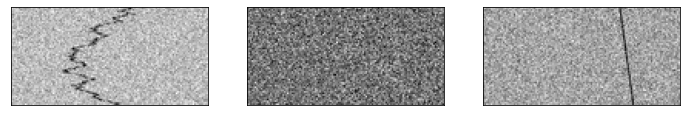

In [18]:
plt.figure(0, figsize=(12,12))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = np.squeeze(x_train[np.random.randint(0,x_train.shape[0])])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap = 'gray')

## Create Training and Validation Data Generators

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.4,
                                   zoom_range=[0.8, 1.2],
                                   horizontal_flip=True,
                                  vertical_flip=True,
                                   fill_mode='wrap'
                                  )
datagen_train.fit(x_train)

datagen_val = ImageDataGenerator(rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.4,
                                   zoom_range=[0.8, 1.2],
                                   horizontal_flip=True,
                                  vertical_flip=True,
                                   fill_mode='wrap')
datagen_val.fit(x_val)

## CNN Model

In [9]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from time import time

In [10]:
# Initialising the CNN
model = Sequential()

# 1st Convolution
model.add(Conv2D(32, (5,5), padding='same', input_shape=(64, 128, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(64, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(4, activation='softmax'))

## Learning Rate Scheduling and Compiling the Model

In [11]:
initial_learning_rate = 0.005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = initial_learning_rate,
    decay_steps = 5,
    decay_rate = 0.96,
    staircase = True
)
optimizer = Adam(learning_rate=lr_schedule)

In [12]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 128, 32)       832       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 128, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 64, 128, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 128, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 128, 64)       51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 128, 64)       256       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 128, 64)       0

## Training the Model

In [14]:
checkpoint = ModelCheckpoint(filepath='model_weight2.h5', monitor='val_loss', 
                             save_weights_only=True, mode='min', verbose=0)
callbacks = [TensorBoard(log_dir='C:/tensorflowLogs/{}'.format(time())), checkpoint]

batch_size = 32

history = model.fit(
    datagen_train.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
    steps_per_epoch = len(x_train) // batch_size,
    validation_data = datagen_val.flow(x_val, y_val, batch_size=batch_size, shuffle=True),
    validation_steps = len(x_val) // batch_size,
    epochs = 12,
    callbacks=callbacks
)

Epoch 1/12
100/100 [==============================] - 11s 108ms/step - loss: 0.6200 - accuracy: 0.6753 - val_loss: 1.9981 - val_accuracy: 0.4150
Epoch 2/12
100/100 [==============================] - 10s 103ms/step - loss: 0.5620 - accuracy: 0.6900 - val_loss: 3.0019 - val_accuracy: 0.2575
Epoch 3/12
100/100 [==============================] - 10s 102ms/step - loss: 0.5457 - accuracy: 0.6831 - val_loss: 2.5272 - val_accuracy: 0.2500
Epoch 4/12
100/100 [==============================] - 10s 102ms/step - loss: 0.5385 - accuracy: 0.6919 - val_loss: 1.7069 - val_accuracy: 0.4925
Epoch 5/12
100/100 [==============================] - 10s 102ms/step - loss: 0.5084 - accuracy: 0.7025 - val_loss: 1.8085 - val_accuracy: 0.5000
Epoch 6/12
100/100 [==============================] - 10s 103ms/step - loss: 0.4886 - accuracy: 0.7181 - val_loss: 1.5989 - val_accuracy: 0.5000
Epoch 7/12
100/100 [==============================] - 10s 102ms/step - loss: 0.4720 - accuracy: 0.7337 - val_loss: 1.1894 - val_ac

## Model Evaluation

In [15]:
model.evaluate(x_val, y_val)

25/25 [==============================] - 1s 21ms/step - loss: 0.4157 - accuracy: 0.7362


[0.41565367579460144, 0.7362499833106995]

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
#import seaborn as sns

y_true = np.argmax(y_val, 1)
y_pred = np.argmax(model.predict(x_val), 1)
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       200
           1       0.48      0.34      0.40       200
           2       0.49      0.61      0.54       200
           3       1.00      1.00      1.00       200

    accuracy                           0.74       800
   macro avg       0.73      0.74      0.73       800
weighted avg       0.73      0.74      0.73       800



In [17]:
print("Classification accuracy: %0.6f" %metrics.accuracy_score(y_true, y_pred))

Classification accuracy: 0.736250
